In [1]:
library('tidyverse')
library('rvest')
library('lubridate')
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




In [2]:
scrape_table = function(i, MF='Women\'s') {
    url = "https://www.baa.org/races/boston-marathon/results/champions"
    webpage = xml2::read_html(url)
    tbl = html_nodes(webpage, "table")[[i]] %>%
        html_table() %>%
        drop_na() %>%
        magrittr::set_colnames(c('year', 'name', 'country', 'time')) %>%
        mutate(time = hms(time)) %>%
        mutate(year = as.Date(paste(year, 1, 1, sep = '-')))%>%
        mutate(race.time = as.numeric(time, 'hours')) %>%
        mutate(MF = MF) %>%
        mutate(
            country.simple = ifelse(
                country %in% c('United States', 'Ethiopia', 'Japan', 'Kenya'),
                country,
                'other'
            )
        )
    tbl
}

df.men = scrape_table(1, MF='Men\'s')
df.women = scrape_table(2)

df.marathon = rbind(df.men, df.women)

Preview the data (i.e. `df.marathon`).

In [3]:
df.marathon|>head()

year,name,country,time,race.time,MF,country.simple
<date>,<chr>,<chr>,<Period>,<dbl>,<chr>,<chr>
2024-01-01,Sisay Lemma,Ethiopia,2H 6M 17S,2.104722,Men's,Ethiopia
2023-01-01,Evans Chebet,Kenya,2H 5M 54S,2.098333,Men's,Kenya
2022-01-01,Evans Chebet,Kenya,2H 6M 51S,2.114167,Men's,Kenya
2021-01-01,Benson Kipruto,Kenya,2H 9M 51S,2.164167,Men's,Kenya
2019-01-01,Lawrence Cherono,Kenya,2H 7M 57S,2.132500,Men's,Kenya
2018-01-01,Yuki Kawauchi,Japan,2H 15M 58S,2.266111,Men's,Japan


Fill in the table below:

| chart property | column name |
| --- | --- |
| x value | year |
| y value | race.time |
| color | country |
| facet value | MF|

Note of other aesthetic decisions. 
- y-axis title: Winning time
- Do the two charts share the same x-axis bounds? No
- Is there a legend? No

Code your version of the chart below.

In [4]:
country_labels = tribble(
    ~year, ~race.time, ~country.simple, ~MF,
    1980, 3, "United States", "Women's",
    2000, 2.6, "Ethiopia", "Women's",
    2010, 2.25, "Kenya", "Women's",
    1920, 2.8, "United States", "Men's",
    1960, 2.1, "Japan", "Men's",
    2000, 2.0, "Kenya", "Men's"
)|> mutate(
        year = as.Date(paste(year, 1, 1, sep = '-')),
        time = dhours(race.time)
    )
country_labels

year,race.time,country.simple,MF,time
<date>,<dbl>,<chr>,<chr>,<Duration>
1980-01-01,3.00,United States,Women's,10800s (~3 hours)
2000-01-01,2.60,Ethiopia,Women's,9360s (~2.6 hours)
2010-01-01,2.25,Kenya,Women's,8100s (~2.25 hours)
1920-01-01,2.80,United States,Men's,10080s (~2.8 hours)
1960-01-01,2.10,Japan,Men's,7560s (~2.1 hours)
2000-01-01,2.00,Kenya,Men's,7200s (~2 hours)


In [5]:
df.marathon |> 
   mutate(
       country_w_other = ifelse(country %in% c('United States', 'Ethiopia', 'Kenya', 'Japan'), country, 'other')
   ) |>
   head()

year,name,country,time,race.time,MF,country.simple,country_w_other
<date>,<chr>,<chr>,<Period>,<dbl>,<chr>,<chr>,<chr>
2024-01-01,Sisay Lemma,Ethiopia,2H 6M 17S,2.104722,Men's,Ethiopia,Ethiopia
2023-01-01,Evans Chebet,Kenya,2H 5M 54S,2.098333,Men's,Kenya,Kenya
2022-01-01,Evans Chebet,Kenya,2H 6M 51S,2.114167,Men's,Kenya,Kenya
2021-01-01,Benson Kipruto,Kenya,2H 9M 51S,2.164167,Men's,Kenya,Kenya
2019-01-01,Lawrence Cherono,Kenya,2H 7M 57S,2.132500,Men's,Kenya,Kenya
2018-01-01,Yuki Kawauchi,Japan,2H 15M 58S,2.266111,Men's,Japan,Japan


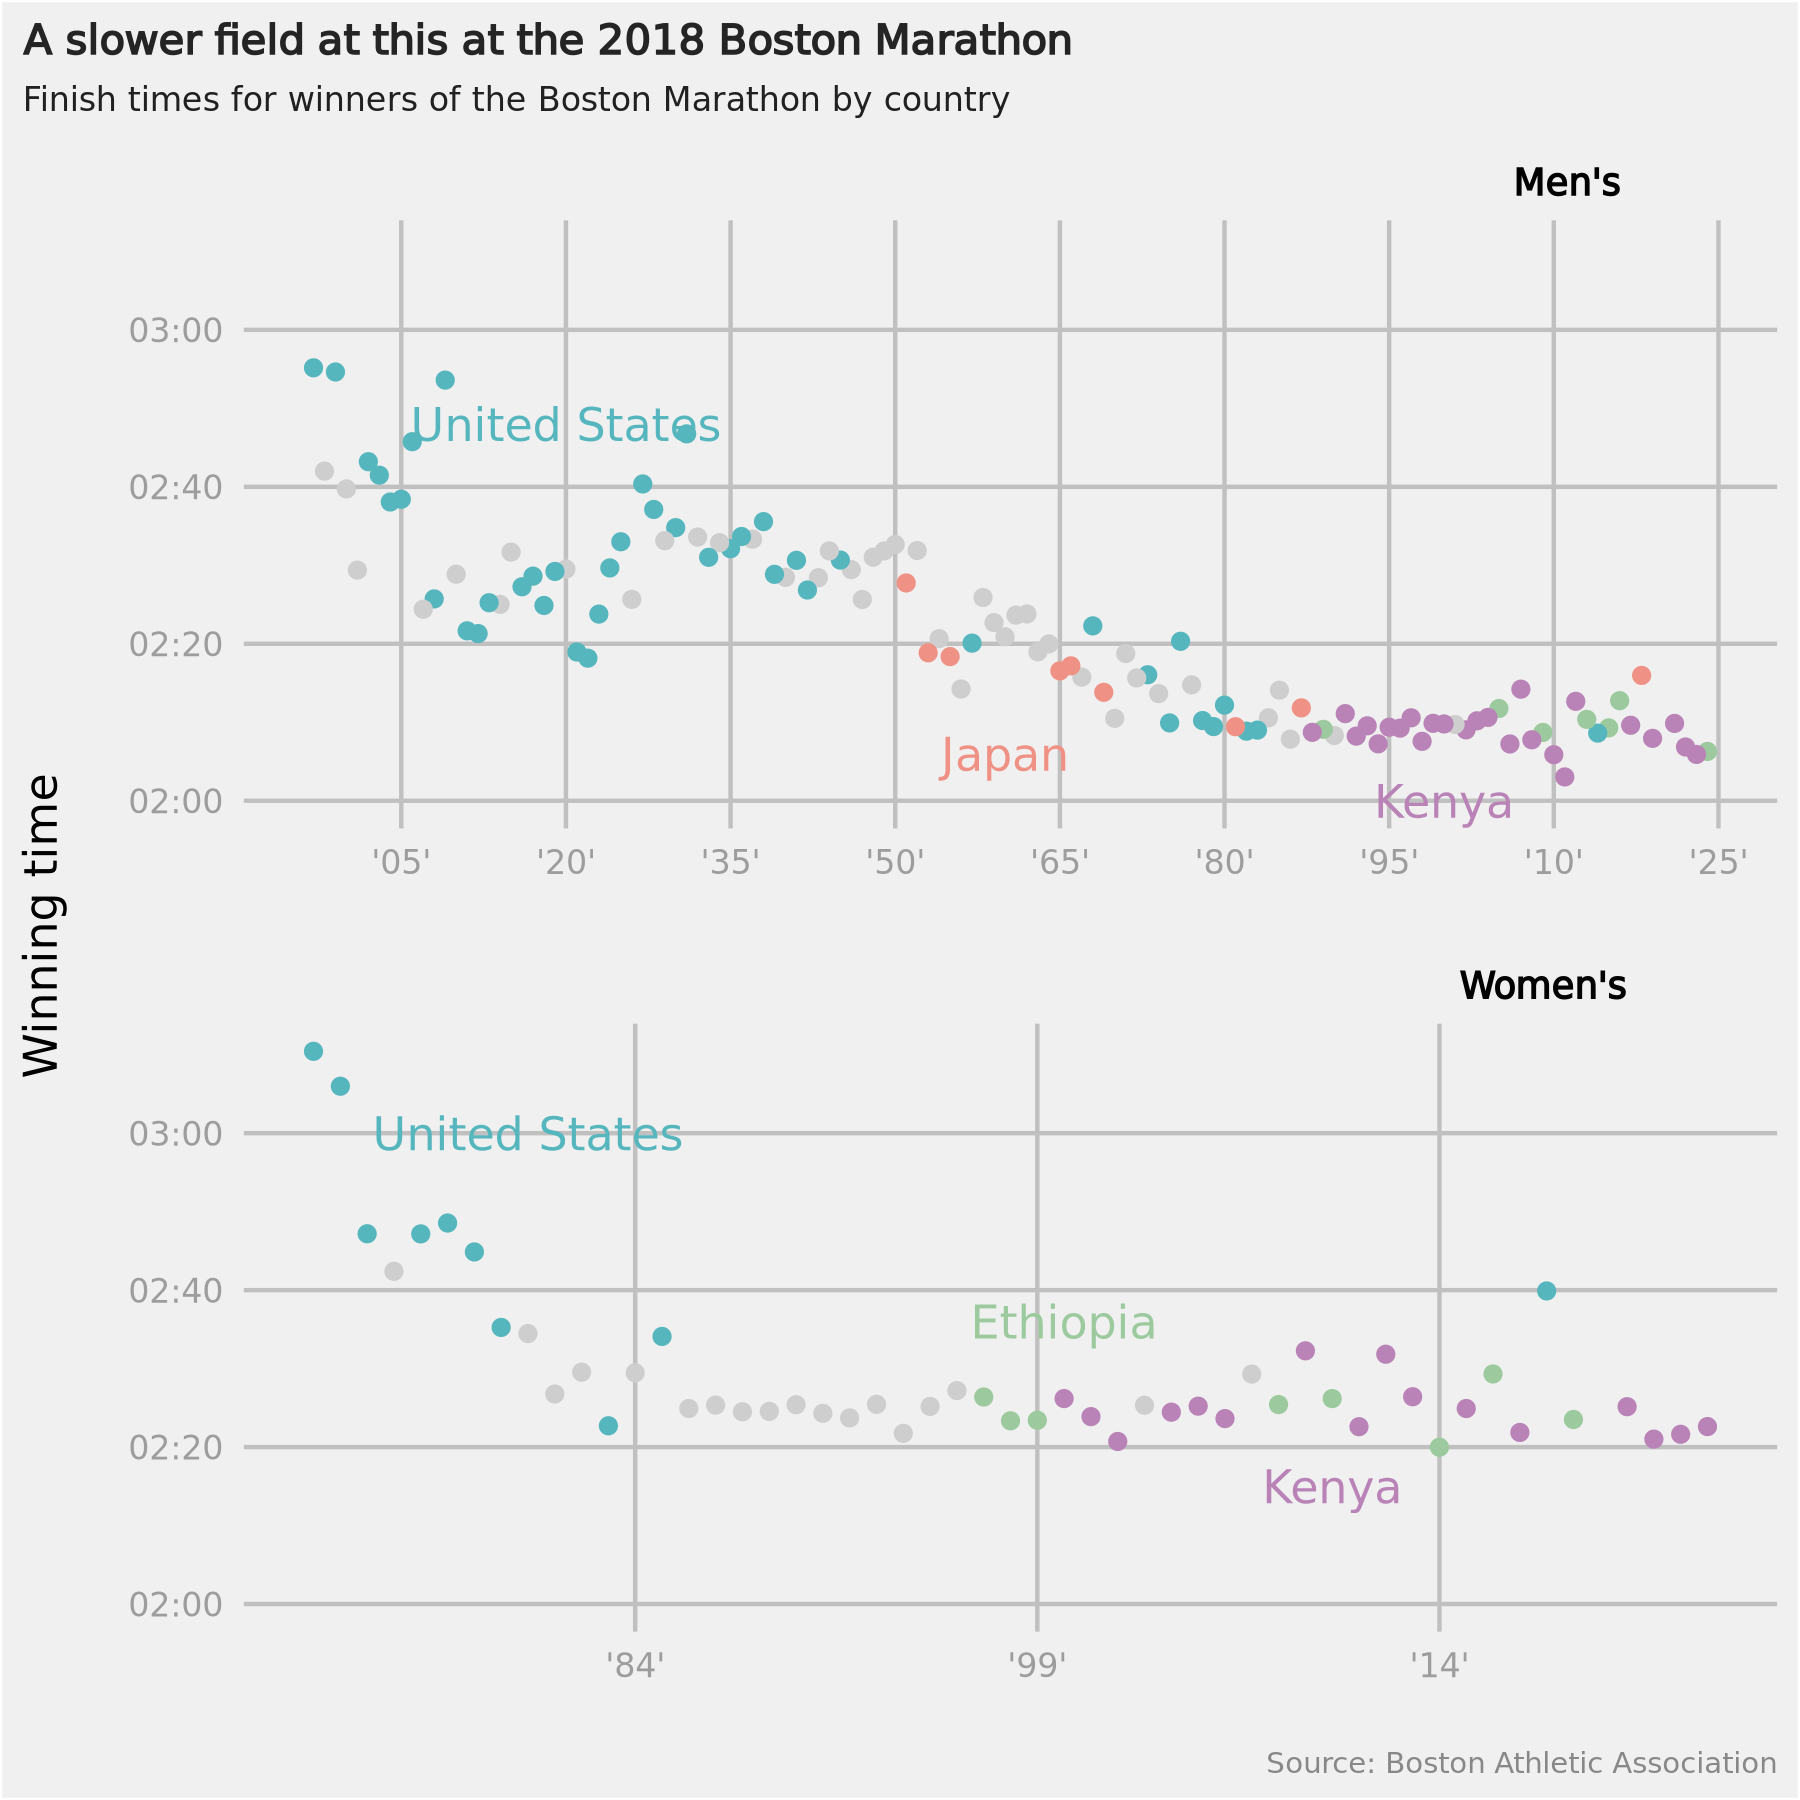

In [6]:
colors = c('#9cca9e', '#ef9285', '#b983b7', '#56b6be', '#cecece') #the code to adjust how deep the color will be
bg = '#f0f0f0'

ggplot(df.marathon, aes(x=year, y=time, color=country.simple))+
        geom_point()+
        geom_text(data = country_labels, mapping = aes (label=country.simple))+
        facet_wrap(~MF, ncol=1, scales='free_x')+
        labs(
            title = 'A slower field at this at the 2018 Boston Marathon',
            subtitle = 'Finish times for winners of the Boston Marathon by country',
            caption = 'Source: Boston Athletic Association',
            x = NULL,
            y = 'Winning time'
        )+
        theme(
            legend.position = 'none',
            panel.background = element_rect(fill = bg),
            panel.spacing = unit(0.5, 'cm'),
            panel.grid.major = element_line(color = '#c0c0c0'),
            panel.grid.minor = element_blank(),
            strip.background = element_blank(),
            strip.text = element_text(hjust = 0.9, color = '#010101', face = 'bold'),
            plot.background = element_rect(fill = bg),
            plot.title.position = 'plot',
            plot.caption.position = 'plot',
            plot.title = element_text(color = '#242424', face = 'bold', size = 10),
            plot.subtitle = element_text(color = '#212121', size = 8),
            plot.caption = element_text(color = '#888888', size = 7, margin = margin(t = 15, r =0, b = 0, l = 0, unit ='pt')),
            axis.ticks = element_blank(),
            axis.text = element_text(color = '#9d9d9d', family = 'DecimaMonoPro',size =8),
            axis.title.y = element_text(margin = margin(t = 0, r =15, b=0, l=0, unit='pt'))
        )+
        scale_color_manual(values = colors)+
        scale_x_date(date_breaks = '15 years', date_labels = "'%y'")+
        scale_y_time(labels = scales::label_time(format = '%H:%M'))

What else might you visualize with this data? (e.g. What about totaling the winners from each country?)